In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1 shap

# Inline plots
%matplotlib inline

import json
import pandas as pd
import numpy as np
import lightgbm as lgb
from numerapi import NumerAPI
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import shap
import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/envs/numerai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!python --version

Python 3.11.10


In [4]:
import cloudpickle
print(cloudpickle.__version__)

2.2.1


In [5]:
# Initialize NumerAPI
napi = NumerAPI()

# Set data version
DATA_VERSION = "v5.0"

# Download feature metadata
napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
all_features = feature_metadata["feature_sets"]["all"]
target_cols = feature_metadata["targets"]

# Download training data
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Load training data with all features and targets
train = pd.read_parquet(
    f"./{DATA_VERSION}/train.parquet",
    columns=["era", "data_type"] + all_features + target_cols
)

# Use every 4th era for training to reduce data size
train = train[train["era"].isin(train["era"].unique()[::4])].reset_index(drop=True)


2025-02-04 08:17:01,693 INFO numerapi.utils: target file already exists
2025-02-04 08:17:01,695 INFO numerapi.utils: download complete
2025-02-04 08:17:02,868 INFO numerapi.utils: target file already exists
2025-02-04 08:17:02,869 INFO numerapi.utils: download complete


## Feature selection using LGBM cumulative feature importance on train

In [20]:
# Define the LightGBM model
model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5 - 1,
    verbose=-1,
    colsample_bytree=0.1
)

# Train the model on all features
model.fit(train[all_features], train["target"])

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': model.feature_importances_
})

# Sort features by importance
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# Select top N features (e.g., 225)
top_n = 225
top_features_lgb = feature_importances.head(top_n)['feature'].tolist()


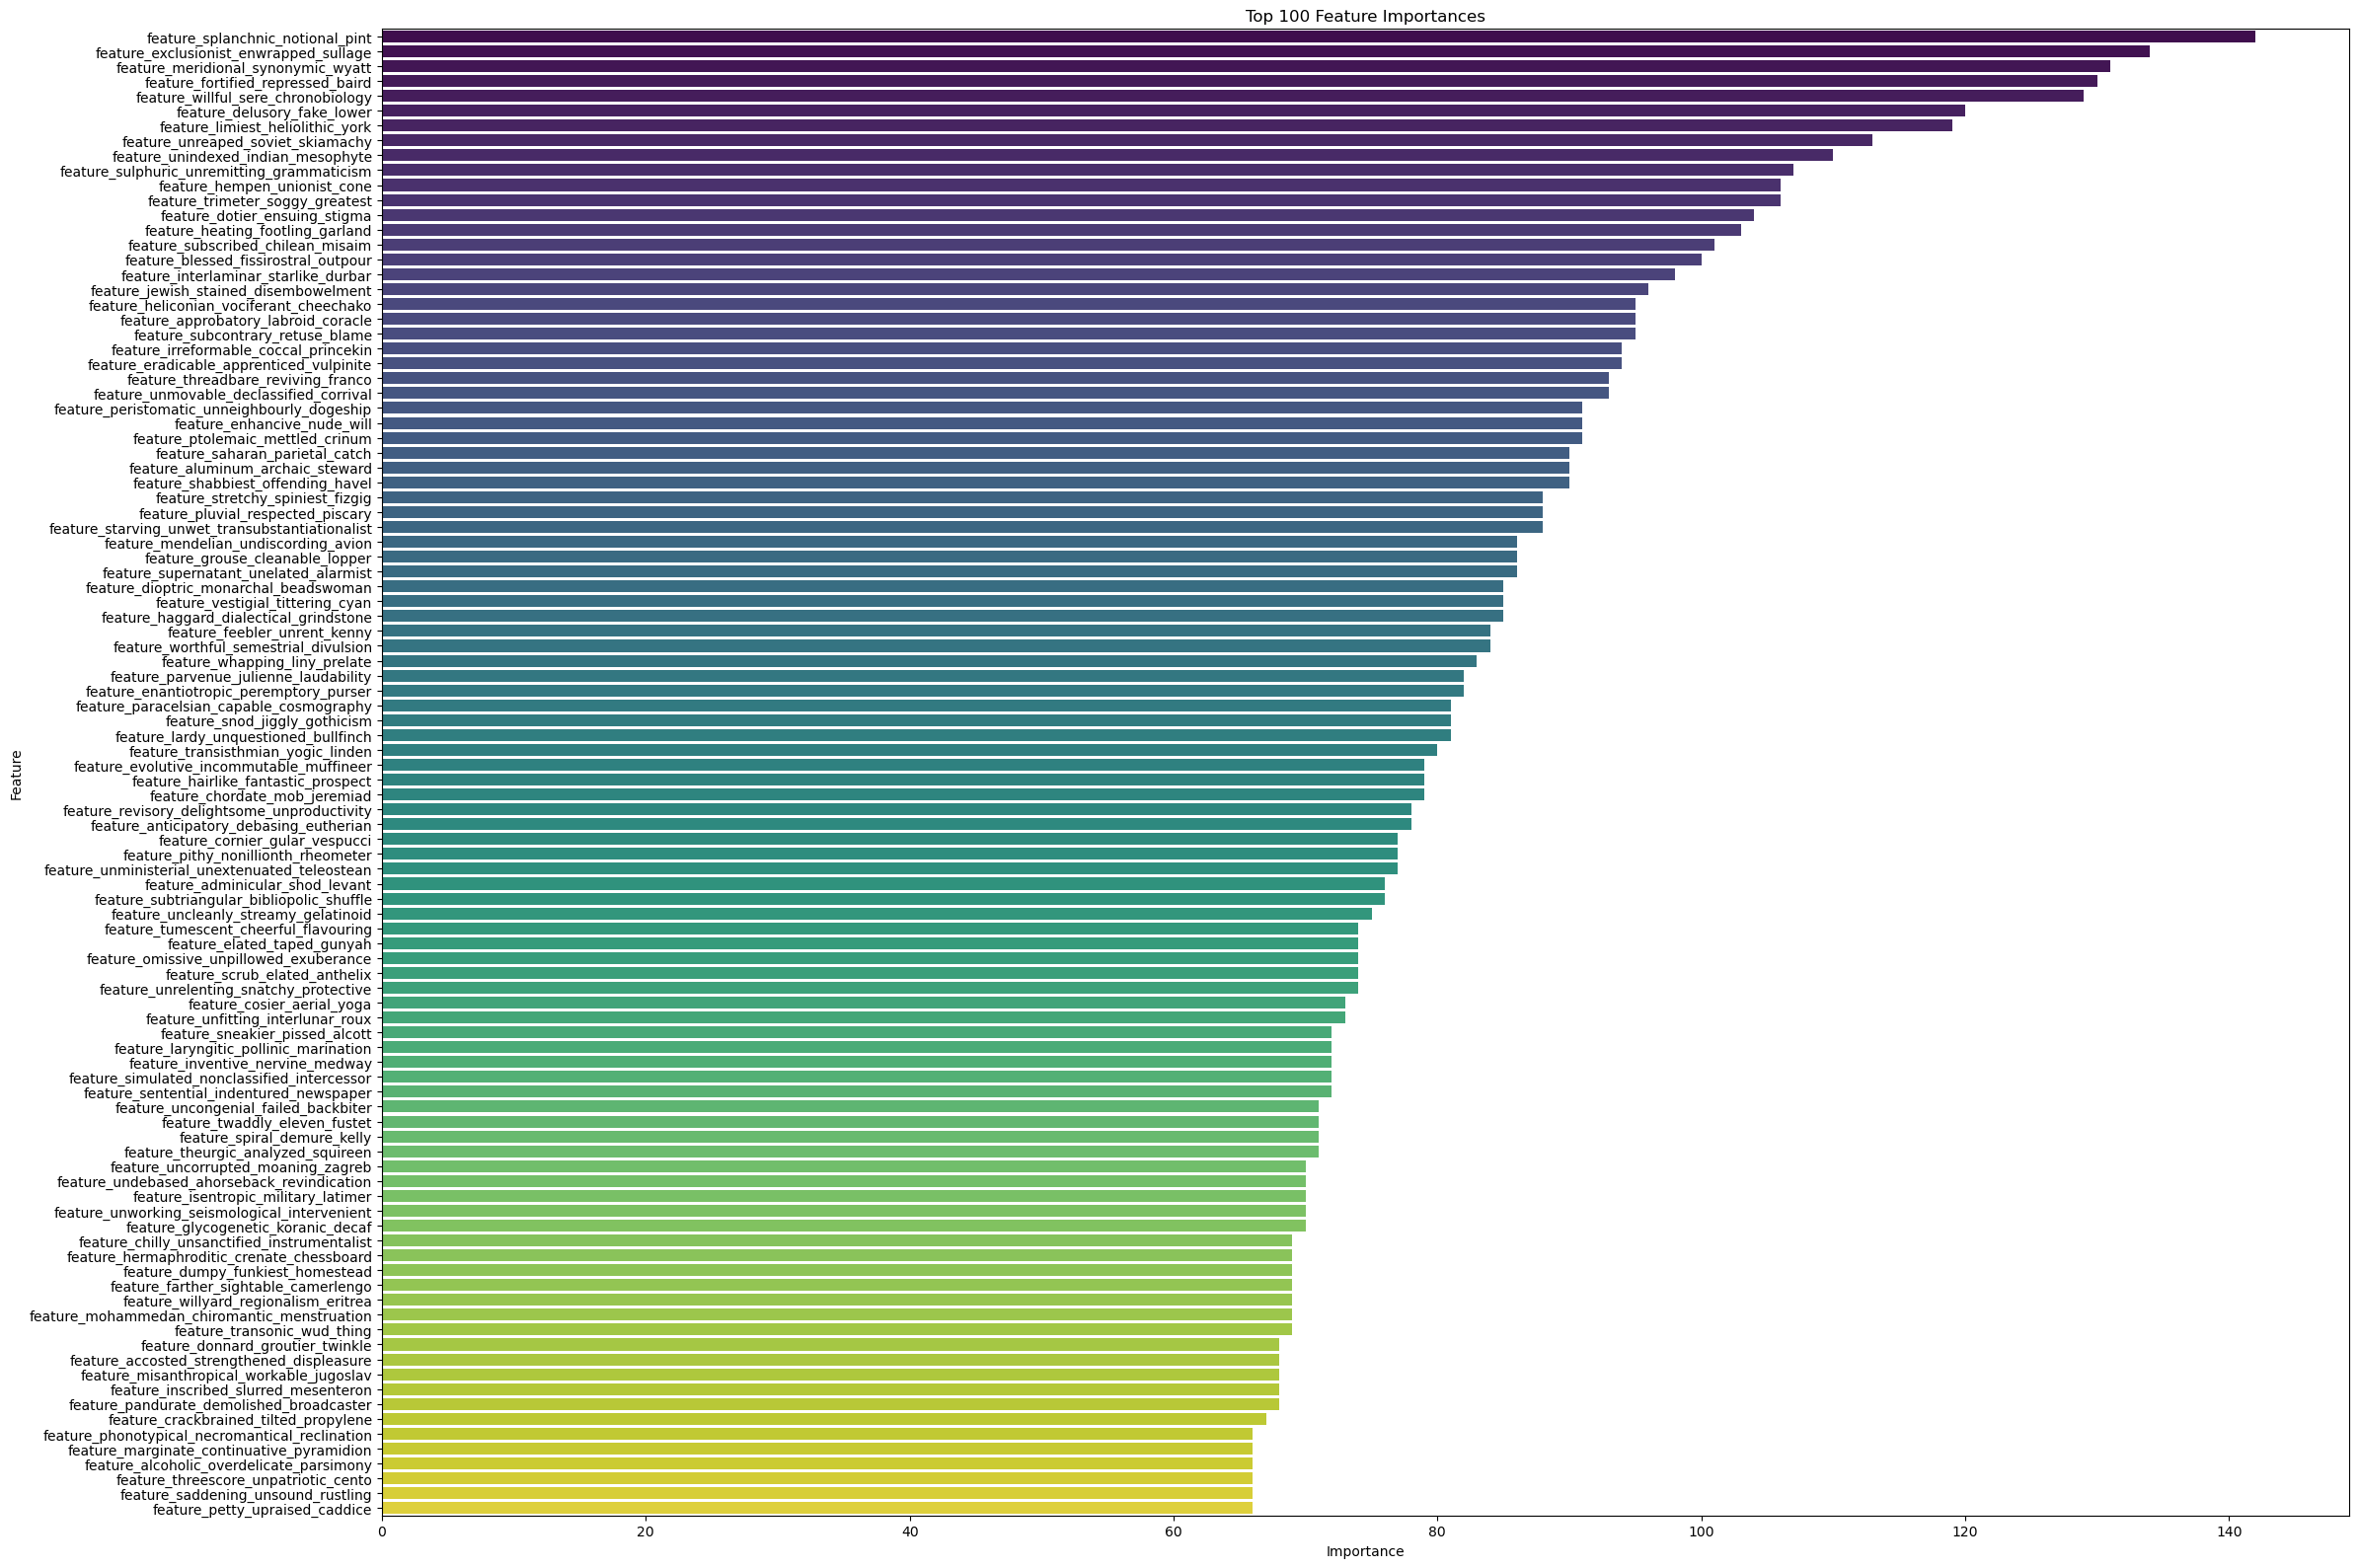

In [21]:
import seaborn as sns

# Reset index after sorting
feature_importances.reset_index(drop=True, inplace=True)

# Plot the top 100 feature importances
plt.figure(figsize=(24, 16))
sns.barplot(x='importance', y='feature', data=feature_importances.head(100), palette='viridis')
plt.title('Top 100 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

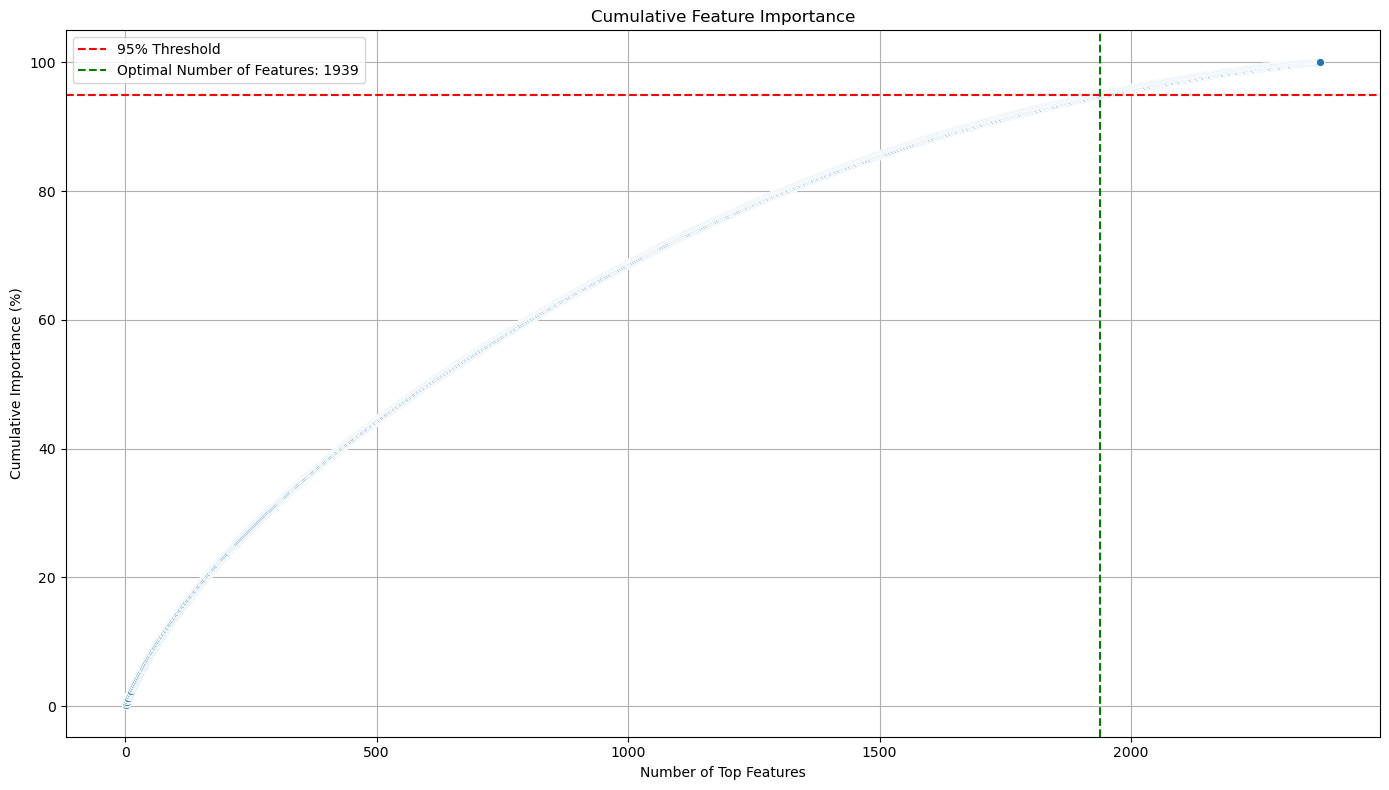

In [22]:
# Calculate cumulative importance
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()

# Normalize cumulative importance to percentage
total_importance = feature_importances['importance'].sum()
feature_importances['cumulative_importance_percentage'] = feature_importances['cumulative_importance'] / total_importance * 100

# Plot cumulative importance
plt.figure(figsize=(14, 8))
sns.lineplot(x=feature_importances.index + 1, y='cumulative_importance_percentage', data=feature_importances, marker='o')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance (%)')
plt.grid(True)

# Highlight the point where cumulative importance exceeds 95%
threshold = 95
optimal_n = feature_importances[feature_importances['cumulative_importance_percentage'] >= threshold].index[0] + 1
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.axvline(x=optimal_n, color='g', linestyle='--', label=f'Optimal Number of Features: {optimal_n}')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
def select_optimal_top_n(feature_importances_df, threshold=95):
    """
    Selects the minimal number of top features required to reach the cumulative importance threshold.

    Parameters:
    - feature_importances_df (pd.DataFrame): DataFrame with 'feature' and 'importance' columns, sorted by 'importance' descending.
    - threshold (float): The cumulative importance threshold in percentage.

    Returns:
    - optimal_n (int): The number of top features to select.
    """
    feature_importances_df = feature_importances_df.copy()
    feature_importances_df['cumulative_importance'] = feature_importances_df['importance'].cumsum()
    total_importance = feature_importances_df['importance'].sum()
    feature_importances_df['cumulative_importance_percentage'] = feature_importances_df['cumulative_importance'] / total_importance * 100
    optimal_n = feature_importances_df[feature_importances_df['cumulative_importance_percentage'] >= threshold].index[0] + 1
    return optimal_n


In [24]:
# Define the cumulative importance threshold
importance_threshold = 60  # in percentage

# Select the optimal number of top features
optimal_top_n = select_optimal_top_n(feature_importances, threshold=importance_threshold)
print(f"Optimal number of top features to reach {importance_threshold}% cumulative importance: {optimal_top_n}")


Optimal number of top features to reach 60% cumulative importance: 801


In [25]:
lgbm_feature_selected = optimal_top_n

## Feature selection using SHAP values cumulative importance

In [26]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

# Compute SHAP values (using a subset for efficiency)
sample_indices = np.random.choice(train.index, size=10000, replace=False)
shap_values = explainer.shap_values(train.loc[sample_indices, all_features])

# Compute mean absolute SHAP values for each feature
shap_importances = pd.DataFrame({
    'feature': all_features,
    'importance': np.mean(np.abs(shap_values), axis=0)
})

# Sort features by SHAP importance
shap_importances.sort_values(by='importance', ascending=False, inplace=True)

# Select top N features
top_features_shap = shap_importances.head(top_n)['feature'].tolist()


In [27]:
len(top_features_shap)

225

In [28]:
# Calculate cumulative importance
shap_importances['cumulative_importance'] = shap_importances['importance'].cumsum()

# Normalize cumulative importance to percentage
total_shap_importance = shap_importances['importance'].sum()
shap_importances['cumulative_importance_percentage'] = shap_importances['cumulative_importance'] / total_shap_importance * 100

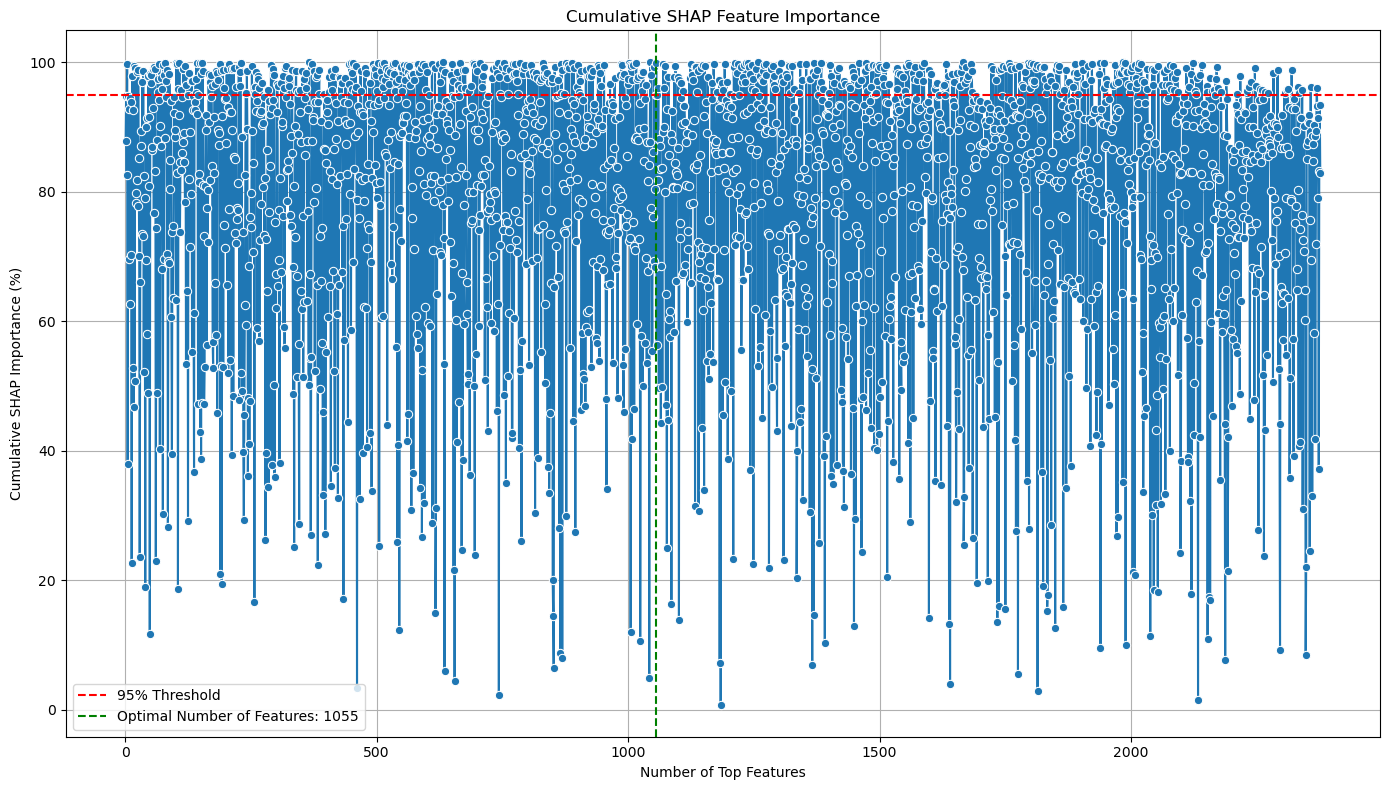

In [29]:
# Plot cumulative SHAP importance
plt.figure(figsize=(14, 8))
sns.lineplot(x=shap_importances.index + 1, y='cumulative_importance_percentage', data=shap_importances, marker='o')
plt.title('Cumulative SHAP Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative SHAP Importance (%)')
plt.grid(True)

# Highlight the point where cumulative importance exceeds 95%
threshold = 95
try:
    optimal_n = shap_importances[shap_importances['cumulative_importance_percentage'] >= threshold].index[0] + 1
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
    plt.axvline(x=optimal_n, color='g', linestyle='--', label=f'Optimal Number of Features: {optimal_n}')
    plt.legend()
except IndexError:
    print(f"Threshold of {threshold}% not reached with available features.")

plt.tight_layout()
plt.show()


In [30]:
def select_optimal_top_n_shap(shap_importances_df, threshold=95):
    """
    Selects the minimal number of top features required to reach the cumulative SHAP importance threshold.

    Parameters:
    - shap_importances_df (pd.DataFrame): DataFrame with 'feature' and 'importance' columns, sorted by 'importance' descending.
    - threshold (float): The cumulative importance threshold in percentage.

    Returns:
    - optimal_n (int): The number of top features to select.
    """
    shap_importances_df = shap_importances_df.copy()
    shap_importances_df['cumulative_importance'] = shap_importances_df['importance'].cumsum()
    total_importance = shap_importances_df['importance'].sum()
    shap_importances_df['cumulative_importance_percentage'] = shap_importances_df['cumulative_importance'] / total_importance * 100
    try:
        optimal_n = shap_importances_df[shap_importances_df['cumulative_importance_percentage'] >= threshold].index[0] + 1
    except IndexError:
        # If threshold not reached, return the total number of features
        optimal_n = len(shap_importances_df)
        print(f"Threshold of {threshold}% not reached. Selecting all {optimal_n} features.")
    return optimal_n


In [31]:
# Define the cumulative importance threshold
shap_threshold = 99.999  # in percentage

# Select the optimal number of top features based on the SHAP threshold
optimal_top_n_shap = select_optimal_top_n_shap(shap_importances, threshold=shap_threshold)
print(f"\nOptimal number of top features to reach {shap_threshold}% cumulative SHAP importance: {optimal_top_n_shap}")



Optimal number of top features to reach 99.999% cumulative SHAP importance: 632


## Feature Selection using Mean Decrease Accuracy (MDA) Feature Importance

In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def MDA(model, features, test_set, target_col):
    """
    Mean Decrease Accuracy (MDA) feature importance.

    Parameters:
    - model: Pre-fitted model.
    - features: List of feature names.
    - test_set: DataFrame containing test data.
    - target_col: Name of the target column.

    Returns:
    - List of tuples (feature, importance score)
    """
    # Predict with the pre-fitted model on the test set
    y_pred = model.predict(test_set[features])
    base_score = np.corrcoef(y_pred, test_set[target_col])[0, 1]
    print(f"Base correlation: {base_score:.5f}")
    feature_importance = []

    for col in features:
        test_set_shuffled = test_set.copy()
        # Shuffle the feature column
        test_set_shuffled[col] = np.random.permutation(test_set_shuffled[col].values)
        # Predict with the shuffled feature
        y_pred_shuffled = model.predict(test_set_shuffled[features])
        shuffled_score = np.corrcoef(y_pred_shuffled, test_set_shuffled[target_col])[0, 1]
        importance = base_score - shuffled_score
        feature_importance.append((col, importance))
        print(f"Feature: {col}, Importance: {importance:.5f}")

    # Sort features by importance
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    return feature_importance

# Example usage:

# Assuming 'train' DataFrame is already loaded and contains 'all_features' and 'target' columns
# Replace 'train' with your actual training DataFrame variable name

# Split data into training and testing sets for MDA
X_train_mda, X_test_mda, y_train_mda, y_test_mda = train_test_split(
    train[all_features], train["target"], test_size=0.2, random_state=42
)

# Fit the model on training data
model_mda = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5 - 1,
    colsample_bytree=0.1,
    verbose=-1
)
model_mda.fit(X_train_mda, y_train_mda)

# Prepare test set for MDA
test_set_mda = X_test_mda.copy()
test_set_mda["target"] = y_test_mda

# Get MDA feature importances
mda_importances = MDA(model_mda, all_features, test_set_mda, "target")

# Convert the list of tuples to a DataFrame for easier manipulation
mda_importances_df = pd.DataFrame(mda_importances, columns=['feature', 'importance'])

# Calculate cumulative importance
mda_importances_df['cumulative_importance'] = mda_importances_df['importance'].cumsum()

# Calculate the total importance
total_importance = mda_importances_df['importance'].sum()

# Calculate cumulative importance percentage
mda_importances_df['cumulative_importance_percentage'] = (mda_importances_df['cumulative_importance'] / total_importance) * 100

# Determine the optimal number of top features to reach 99.999% cumulative importance
threshold = 99.999
optimal_n = mda_importances_df[mda_importances_df['cumulative_importance_percentage'] >= threshold].index[0] + 1
print(f"\nOptimal number of top features to reach {threshold}% cumulative importance: {optimal_n}")

# Select the top features based on the optimal_n
top_features_mda = mda_importances_df.head(optimal_n)['feature'].tolist()
print(f"\nTop {optimal_n} features selected based on {threshold}% cumulative importance:")
print(top_features_mda)


Base correlation: 0.06293
Feature: feature_abessive_philistine_camisado, Importance: -0.00002
Feature: feature_able_deprived_nona, Importance: 0.00002
Feature: feature_ablest_inflexional_egeria, Importance: -0.00003
Feature: feature_abrasive_forcipate_crewel, Importance: 0.00001
Feature: feature_absonant_wintry_hiring, Importance: -0.00003
Feature: feature_absorbable_hyperalgesic_mode, Importance: -0.00001
Feature: feature_absorbing_pluviometrical_technocrat, Importance: -0.00000
Feature: feature_accadian_pledged_bore, Importance: -0.00000
Feature: feature_accepted_unviable_fruitage, Importance: 0.00001
Feature: feature_acclamatory_draconian_view, Importance: -0.00001
Feature: feature_according_tied_bedlam, Importance: -0.00001
Feature: feature_accostable_ambulatory_overcompensation, Importance: -0.00002
Feature: feature_accosted_strengthened_displeasure, Importance: 0.00018
Feature: feature_accountable_uninhabitable_reunion, Importance: 0.00006
Feature: feature_accoutered_revolute_vex

## Walk-Forward Feature Selection using combined feature sets

In [33]:
def walk_forward_feature_selection(train_data, feature_sets, target_col, embargo=5, step=50, use_intersection=True):
    """
    Walk-forward feature selection using intersection or union of feature sets.

    Parameters:
    - train_data: DataFrame containing training data.
    - feature_sets: Dictionary of feature sets from different methods.
    - target_col: Name of the target column.
    - embargo: Number of eras to skip to avoid leakage.
    - step: Number of eras to advance in each iteration.
    - use_intersection: Whether to use intersection (True) or union (False) of feature sets.

    Returns:
    - List of selected features.
    """
    # Combine features from the feature sets
    if use_intersection:
        selected_features = set(feature_sets[next(iter(feature_sets))])  # Start with the first set
        for features in feature_sets.values():
            selected_features.intersection_update(features)
    else:
        selected_features = set()
        for features in feature_sets.values():
            selected_features.update(features)

    # Sort eras
    eras = sorted(train_data["era"].unique())

    for i in range(1, len(eras) // step + 1):
        era_max = eras[min(i * step, len(eras)) - 1]
        era_min = eras[0]
        era_range = eras[:eras.index(era_max) + 1]

        # Split data up to the current era
        data_up_to_era = train_data[train_data["era"].isin(era_range)].reset_index(drop=True)

        # Exclude embargo eras
        embargo_eras_start = eras.index(era_max) + 1
        embargo_eras_end = embargo_eras_start + embargo
        embargo_eras = eras[embargo_eras_start:embargo_eras_end]

        # Validation eras start after the embargo
        validation_eras = eras[embargo_eras_end:embargo_eras_end + step]
        val_subset = train_data[train_data["era"].isin(validation_eras)].reset_index(drop=True)

        # Prepare training data
        train_subset = data_up_to_era[~data_up_to_era["era"].isin(embargo_eras)]

        # Train model on current feature set
        model = lgb.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=5,
            num_leaves=2**5 - 1,
            verbose=-1,
            colsample_bytree=0.1
        )
        model.fit(train_subset[list(selected_features)], train_subset[target_col])

        # Evaluate on validation set
        if not val_subset.empty:
            val_preds = model.predict(val_subset[list(selected_features)])
            val_corr = np.corrcoef(val_preds, val_subset[target_col])[0, 1]
            print(f"Eras {era_min} to {era_max}: Validation CORR = {val_corr:.5f}")
        else:
            print(f"Eras {era_min} to {era_max}: No validation data available.")

        # Optionally, update selected features based on importance
        feature_importances = pd.DataFrame({
            'feature': list(selected_features),
            'importance': model.feature_importances_
        })
        feature_importances.sort_values(by='importance', ascending=False, inplace=True)
        selected_features = set(feature_importances['feature'].tolist())  # Retain all features

    return list(selected_features)

In [36]:
# After calculating optimal_top_n
top_features_lgb = feature_importances.head(optimal_top_n)['feature'].tolist()
print(f"Top {optimal_top_n} features selected based on {importance_threshold}% LightGBM cumulative feature importance.")


Top 801 features selected based on 60% LightGBM cumulative feature importance.


In [35]:
# After calculating optimal_top_n_shap
top_features_shap = shap_importances.head(optimal_top_n_shap)['feature'].tolist()
print(f"Top {optimal_top_n_shap} features selected based on {shap_threshold}% cumulative SHAP importance.")


Top 632 features selected based on 99.999% cumulative SHAP importance.


In [37]:
# Combine feature sets from different methods
feature_sets = {
    # 'lgb': top_features_lgb, # uncomment to include
    'shap': top_features_shap,
    'mda': top_features_mda
}


# # Initialize selected features using the union of top features from all methods
# initial_selected_features = list(set(top_features_lgb).union(top_features_shap).union(top_features_mda))

# # If you have a limit on the number of features (top_n), select the first top_n features
# if len(initial_selected_features) > top_n:
#     initial_selected_features = initial_selected_features[:top_n]

selected_features = walk_forward_feature_selection(
    train_data=train,
    feature_sets=feature_sets,
    target_col="target",
    embargo=5,
    step=50,
    use_intersection=False  # Use union
    # use_intersection=True  # Use intersection

)

Eras 0001 to 0197: Validation CORR = 0.04144
Eras 0001 to 0397: Validation CORR = 0.05254


In [38]:
display(len(top_features_lgb))
display(len(top_features_shap))
display(len(top_features_mda))
display(len(selected_features))

801

632

174

651

In [39]:
import json

# Dictionary of feature lists
feature_data = {
    "top_features_lgb": top_features_lgb,
    "top_features_shap": top_features_shap,
    "top_features_mda": top_features_mda,
    "selected_features": selected_features
}

# Save to JSON
with open("feature_selection.json", "w") as f:
    json.dump(feature_data, f, indent=4)

print("Feature lists saved successfully!")


Feature lists saved successfully!
